In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
import time
import pandas as pd
from statistics import mean
import math
from scipy import constants
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from scipy import asarray as ar, exp, sqrt
from scipy.optimize import curve_fit
plt.rcParams["figure.figsize"] = (20,6)
import os
import sys
from scipy.optimize import curve_fit
import scipy.integrate as si
from scipy.integrate import quad
import shutil
import scienceplots 
plt.style.use(['science', 'notebook', 'grid'])

print (time.ctime())

Tue Apr 18 13:54:07 2023


In [3]:
def exp(t, a, b, T):
    return a*(1-b*np.exp(-t**2/T**2))
def inv_exp(t, a, b, T, t_o):
    return a*(1-b*np.exp(-(t-t_o)/T))
def asymptotic(t, a, b, t_o):
    return a*(1-(b*t_o)/abs(t))

In [4]:
def cut(data, start, stop):
#     data['CH2(V)'].mean()
    
    # cut data before pulse
    data_cut  = data[(data['Time(s)'] > start) & (data['Time(s)'] < stop)]  
    
    # find Y mean of data before pulse
    data_cut.mean()[1]
    
    # Subtract Y mean of data before pulse from total Y data
    data_y_avg = data['CH2(V)'] - data_cut.mean()[1]

    # data_y_avg.shape

    # type(data_y_avg)

    return data_y_avg

In [5]:
def dfconcat(data_1, data_2, start, stop):
    # Combine new averaged Y data with original X data
    data_new = pd.concat([data_1['Time(s)'], data_2], axis=1)
    
    # Remove all data before pulse
#     data_pulse  = data_new[data_new['Time(s)'] > (1.235*(10**(-6)))] 
    data_pulse  = data_new[(data_new['Time(s)'] > start) & (data_new['Time(s)'] < stop)]

    # data_pulse.shape
    return data_pulse

In [6]:
def fit(data, file, npy_dir, func, num, temp, pol, brand, fit_init_guess, fit_bounds):
    fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
#     T=-(10*10**(-6))
#     t_o=-(1*10**(-6))
#     best_vals, covar = curve_fit(func, data['Time(s)'], data['CH2(V)'],p0 = [0.06, 0.8,0.00001], bounds=((0,0,0),(5.0, 0.9,0.001)))
    best_vals, covar = curve_fit(func, data['Time(s)'], data['CH2(V)'],p0 = fit_init_guess, bounds=fit_bounds)
#     best_vals, covar = curve_fit(func, data['Time(s)'], data['CH2(V)'],p0 = [0.06, 1.0, (10*10**(-6))-(4950*(10**(-6))),(1*10**(-6))-(4950*(10**(-6)))], bounds=(0,(5.0,1.0,0.002,1*10**(-5))))
#     best_vals, covar = curve_fit(func, data['Time(s)'], data['CH2(V)'],p0 = [0.06, 1.0, (10*10**(-6))+offset,(1*10**(-6))+offset], bounds=((0,0,0.002+offset-p,(1*10**(-5))+offset-p),(5.0,1.0,0.002+offset,(1*10**(-5))+offset)))
#     best_vals, covar = curve_fit(func, data['Time(s)'], data['CH2(V)'],p0 = [0.06, 1.0, T, t_o], bounds=(-np.inf,(0,0,0,0)))    
    print(best_vals, covar)

    ax.plot(data['Time(s)'], data['CH2(V)'], '-')

#     ax.plot(data['Time(s)'], func(data['Time(s)'], *best_vals),'r-',label='Fit:a-b*e^(-(t-t_o)/T)\n a=%5.4f, b=%5.4f, T=%5.7f, t_o=%5.6f' % tuple(best_vals))
    ax.plot(data['Time(s)'], func(data['Time(s)'], *best_vals),'r-',label='Fit:a*(1-b*e^(-(t-t_o)/T))\n a=%5.4f, b=%5.4f, T=%5.6f t_o=%5.6f' % tuple(best_vals))
#     ax.plot(data['Time(s)'], func(data['Time(s)'], *best_vals),'r-',label='Fit:a*(1-(b*t_o)/abs(t))\n a=%5.4f, b=%5.4f, t_o=%5.6f' % tuple(best_vals))
#     ax.set_title('Optical Pumping, Lin Pol, '+str((num+1)*100)+'uW, 5 ms, Rb @ 40 C')
#     ax.set_title('Optical Pumping, '+pol+' Pol, '+str((num+1)*100)+'uW, 5 ms, Rb @ '+temp+' C')
    ax.set_title('Optical Pumping, '+pol+' Pol, '+str(num)+'uW, 15 ms, Rb @ '+temp+' C') #ThorCIRC60C
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Volts (V)', fontsize=12)
    plt.legend(loc='lower right')
    plt.savefig(file[:-4]+'fit.png')

    np.save(npy_dir+"/"+file.rsplit("/",1)[-1][:-4]+'_'+brand+pol+temp+'_best_vals.npy', best_vals)
    np.save(npy_dir+"/"+file.rsplit("/",1)[-1][:-4]+'_'+brand+pol+temp+'_covar.npy', covar)
    return None

/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/60C_Phase_Locked_15ms/CIRC500uW4.csv
Thu Jan 12 22:32:52 2023


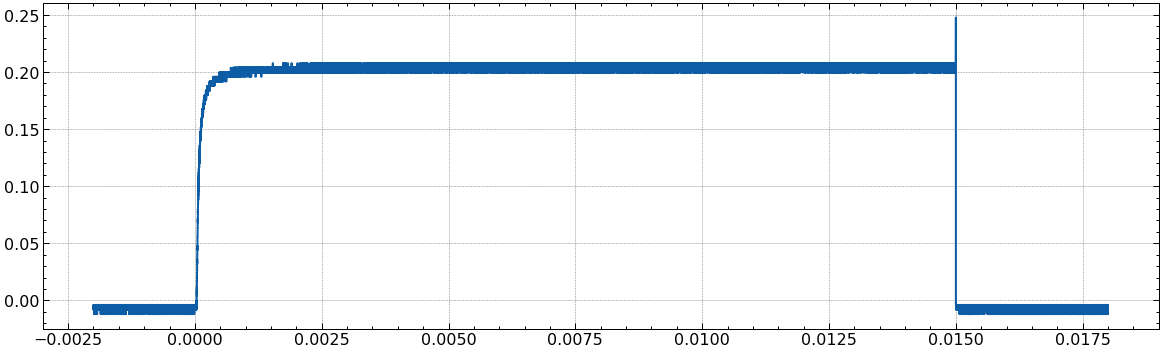

In [67]:
BRANDLONG = 'PrecisionGlassBlowing'
BRAND = 'PGB'
POL = 'CIRC'
TEMP = '60'
# pwrs = [int(x) for x in np.linspace(2000,7500,11)]
# pwrs = [int(x) for x in np.linspace(200, 9000, 11)] # PGB 40C Phasee Lock
# pwrs = [int(x) for x in np.linspace(3650, 9150, 11)] # PGB 60C Phase Lock 2
pwrs = [int(x) for x in np.linspace(500,9000,11)] # PGB 60C Phase Locked 15ms
num = 4
file1 = (root+f"/{POL}{str(pwrs[0])}uW{str(num)}.csv")
print(file1)
print(time.ctime())
data = pd.read_csv(file1)

fig, ax = plt.subplots(figsize = (20,6), facecolor='w')

ax.plot(data['Time(s)'], data['CH2(V)'], '-')
# tick_spacing = 0.0005
# import matplotlib.ticker as ticker
# ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax.set_xlim(1.1*(10**(-6)), (2*(10**(-6))))
# ax.set_xlim(0,1.3*(10**(-6)))
#ax.set_ylim(40000,60000)
ax.grid(True)
# ax.set_xlim(0-(5000*(10**(-6))), (0*(10**(-6))))

# plt.savefig()

[2.11340768e-01 5.00000000e-01 1.84325764e-04 9.46039471e-21] [[ 1.61963307e-12 -3.50394438e-17  5.75348212e-14 -9.50514439e-14]
 [-3.50394438e-17  5.09982870e-20 -6.19495529e-17  1.38342973e-16]
 [ 5.75348212e-14 -6.19495529e-17  7.94448328e-14 -1.68050455e-13]
 [-9.50514439e-14  1.38342973e-16 -1.68050455e-13  3.75282765e-13]]


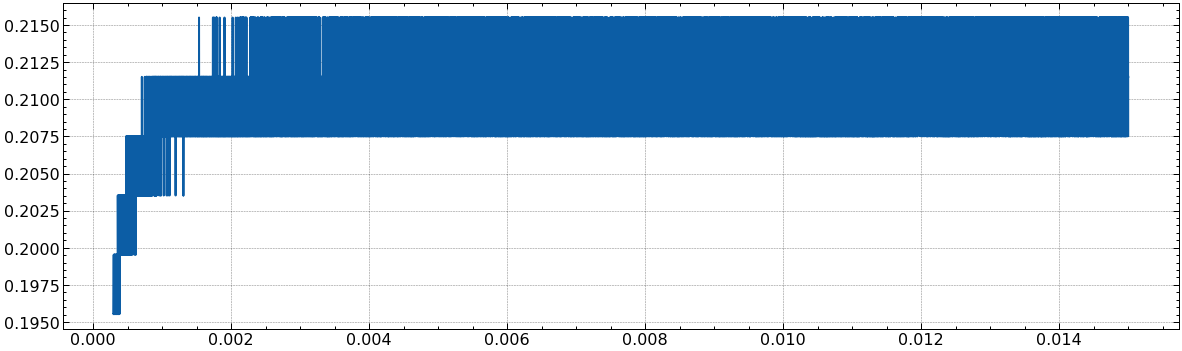

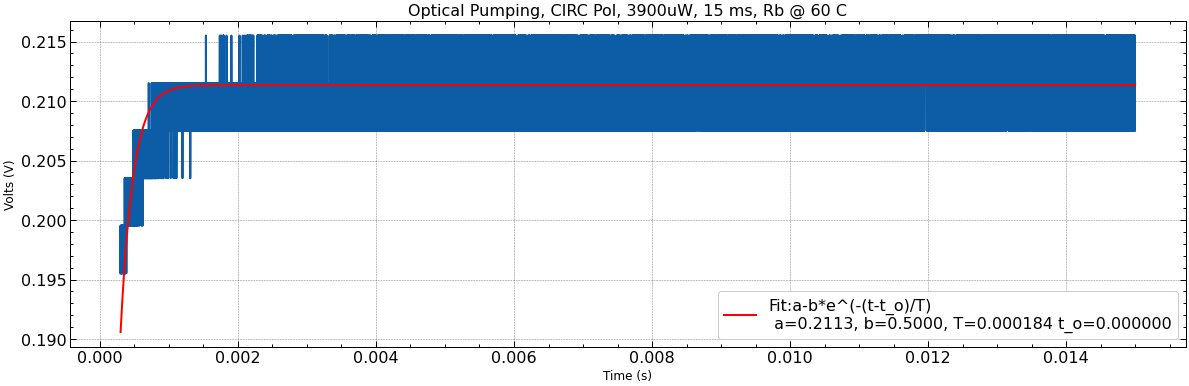

In [71]:
#  Params for datasets 0-4
# data2 = cut(data, data['Time(s)'].min(), 0-(5000*(10**(-6))))
# data3  = dfconcat(data, data2, 0-(4950*(10**(-6))), 0-20*10**-6)

#  Params for datasets 5-10
# data2 = cut(data, data['Time(s)'].min(), 0)
# data3  = dfconcat(data, data2, 1.235*(10**(-6)), 4090*10**-6)

# # PGB 60C Phase Lock 2
# a = data['Time(s)'].min()
# b = 0
# c = 100*(10**(-6))
# d = 4090*10**-6

# PGB 60C Phase Locked 15ms
a = data['Time(s)'].min()
b = 0
c = 300*(10**(-6))
d = 15000*10**-6

data2 = cut(data, a, b)
data3  = dfconcat(data, data2, c, d)

fig, ax = plt.subplots(figsize = (20,6), facecolor='w')

ax.plot(data3['Time(s)'], data3['CH2(V)'], '-')
# ax.set_xlim(0-(5000*(10**(-6))), (0*(10**(-6))))

# filenum = 0
BRANDLONG = 'PrecisionGlassBlowing'
BRAND = 'PGB'
POL = 'CIRC'
TEMP = '60' 


# make new folder if not exists
npydir = (root+"/npy_files")
if not os.path.exists(npydir):
    os.mkdir(npydir)

# inv_exp(t, a, b, T, t_o)
fitInitGuess = [0.06, 0.8, 10*10**(-5), 1*10**(-4)]
fitBounds=((0,0.5,0,0*10**-4),(5.0, 0.9, 0.001, 1*10**(-3)))
fit(data3, file1, npydir, inv_exp, pwrs[num], TEMP, POL, BRAND, fitInitGuess, fitBounds)

In [8]:
BRANDLONG = 'PrecisionGlassBlowing'
BRAND = 'PGB'
POL = 'CIRC'
TEMP = '60' 
root = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
        +f"{BRANDLONG}/{POL}POL/{TEMP}C_Phase_Locked_15ms")

# pwrs = [int(x) for x in np.linspace(2000,7500,11)]
# pwrs = [int(x) for x in np.linspace(200, 9000, 11)] # PGB 40C Phase Lock
# pwrs = [int(x) for x in np.linspace(3650, 9150, 11)] # PGB 60C Phase Lock 2
pwrs = [int(x) for x in np.linspace(500,9000,11)] # PGB 60C Phase Locked 15ms

# make new folder if not exists
npydir = (root+"/npy_files")
if not os.path.exists(npydir):
    os.mkdir(npydir)

/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/60C_Phase_Locked_15ms/CIRC500uW0.csv
Fri Jan 13 00:19:22 2023
[5.40505011e-03 8.41947327e-01 8.43456731e-04 6.24471591e-04] [[ 6.82837746e-14 -4.21786616e-18  4.36792375e-14 -4.21035528e-15]
 [-4.21786616e-18  6.94616351e-20 -6.77571720e-17  6.93379429e-17]
 [ 4.36792375e-14 -6.77571720e-17  2.12212013e-13 -6.76365149e-14]
 [-4.21035528e-15  6.93379429e-17 -6.76365149e-14  6.92144708e-14]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/60C_Phase_Locked_15ms/CIRC500uW1.csv
Fri Jan 13 00:19:27 2023
[4.15331352e-02 8.07617698e-01 2.97940039e-04 1.55650551e-04] [[ 5.24617496e-13 -1.26055391e-18  1.82902807e-14 -3.41703309e-15]
 [-1.26055391e-18  9.60480850e-22 -2.63748412e-18  2.60361357e-18]
 [ 1.82902807e-14 -2.63748412e-18  1.52525535e-14 -7.14953291e-15]
 [-3.41703309e-15  2.60361357e-18 -7.14953291e-15  7.05771869e-15]]
/mnt/e/Google_Drive_Backup_E

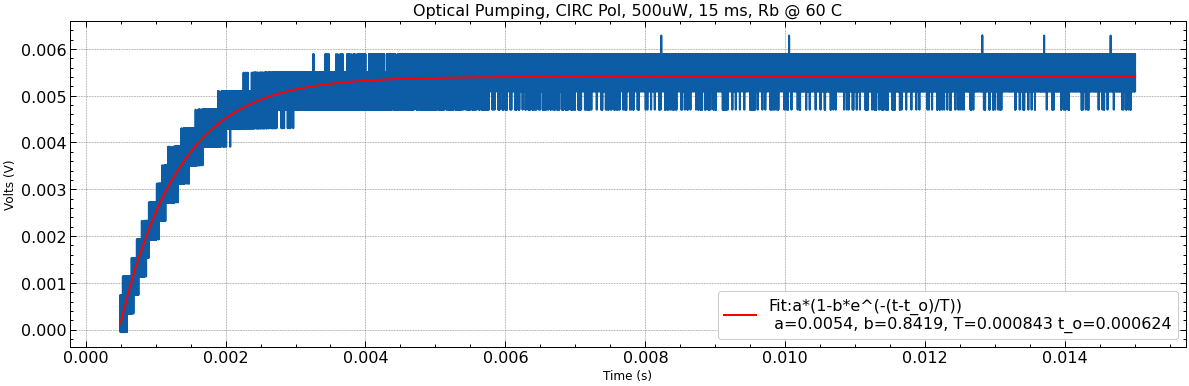

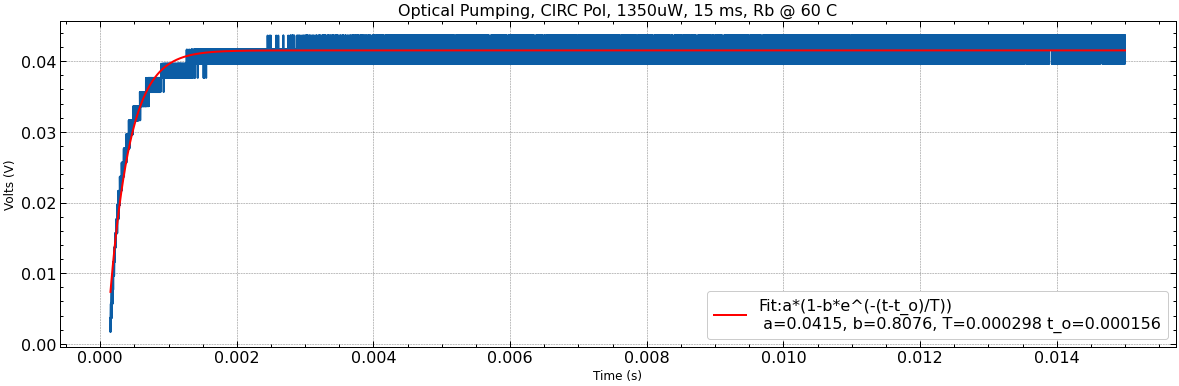

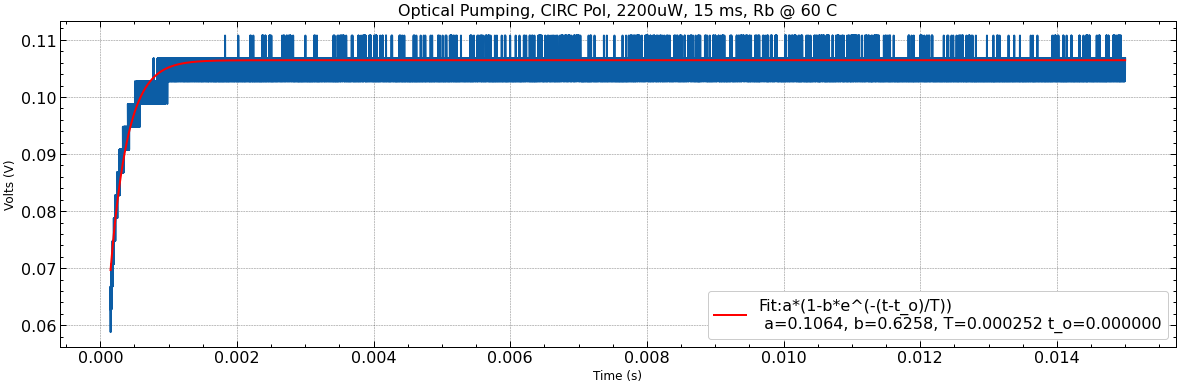

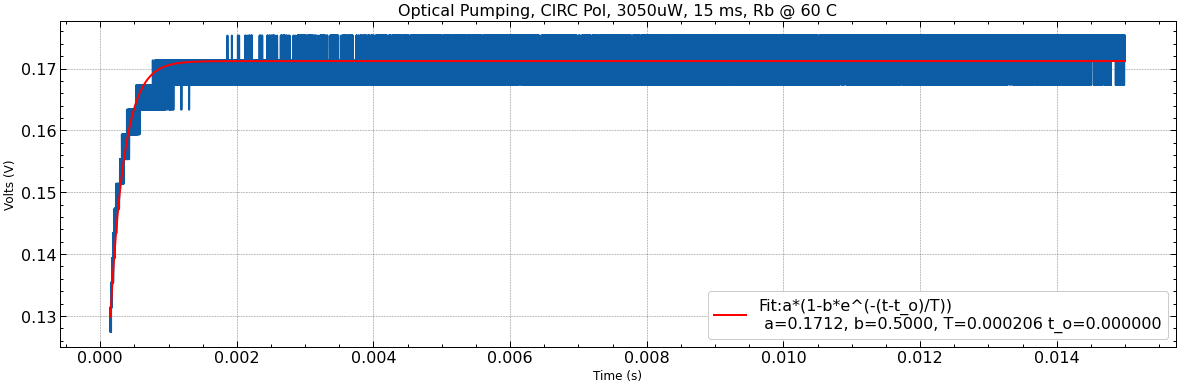

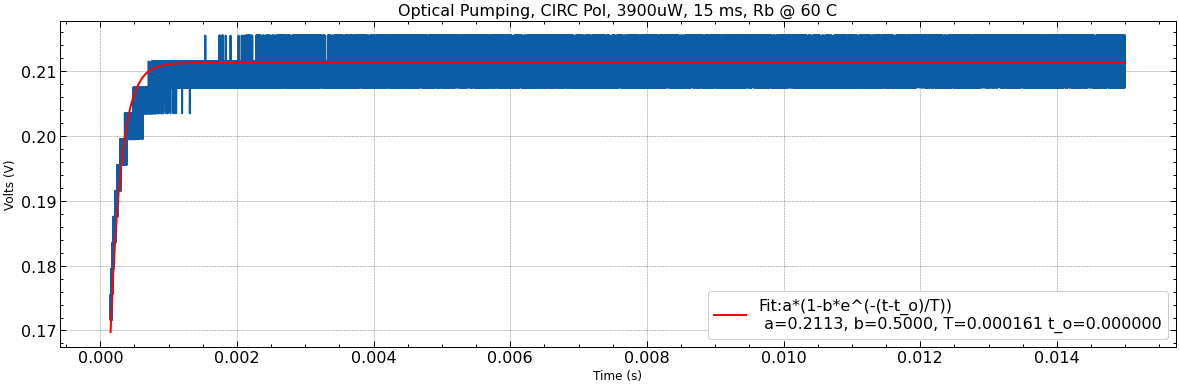

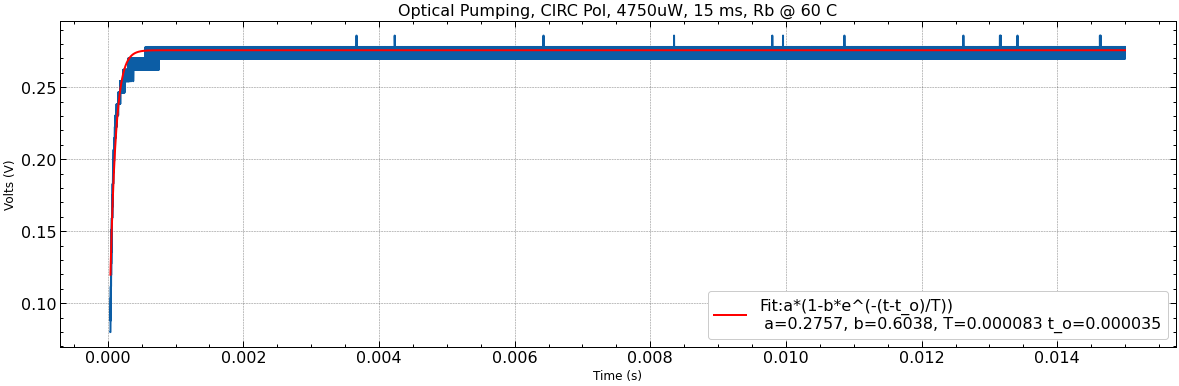

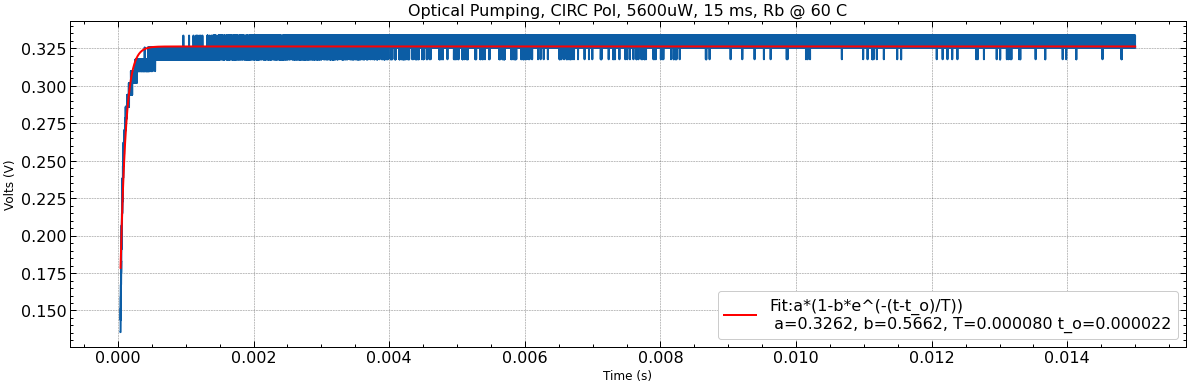

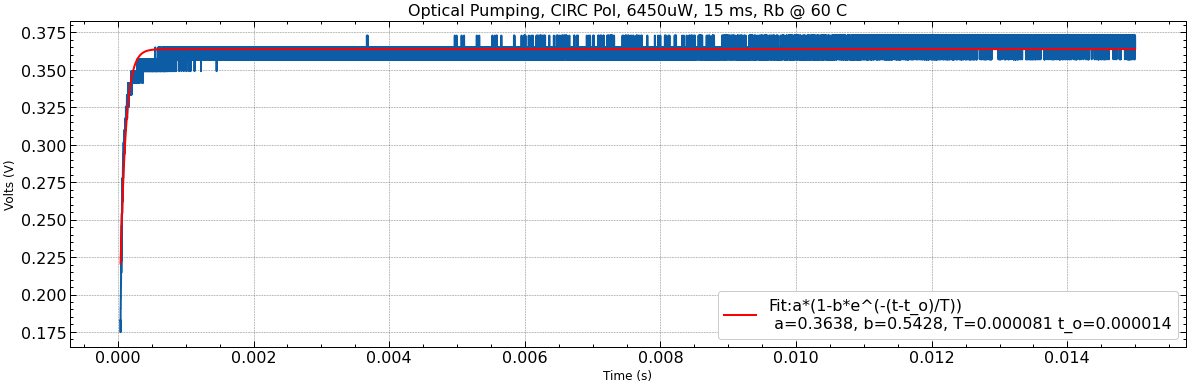

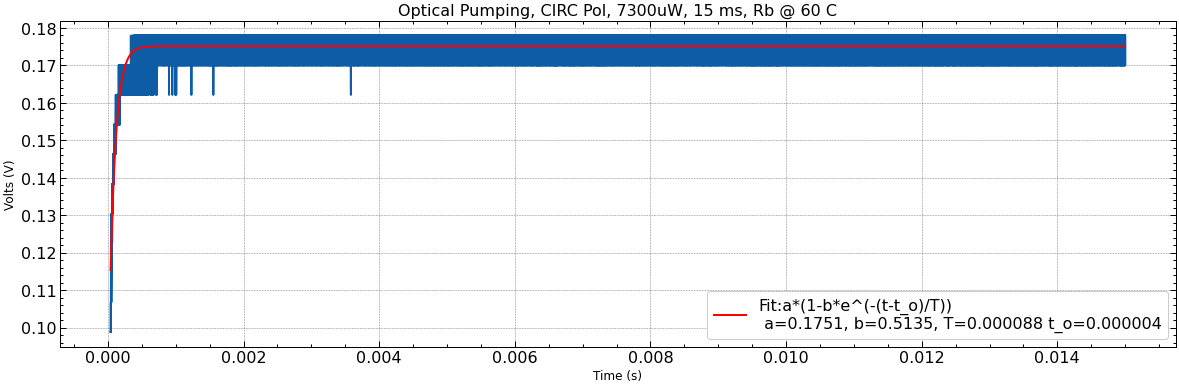

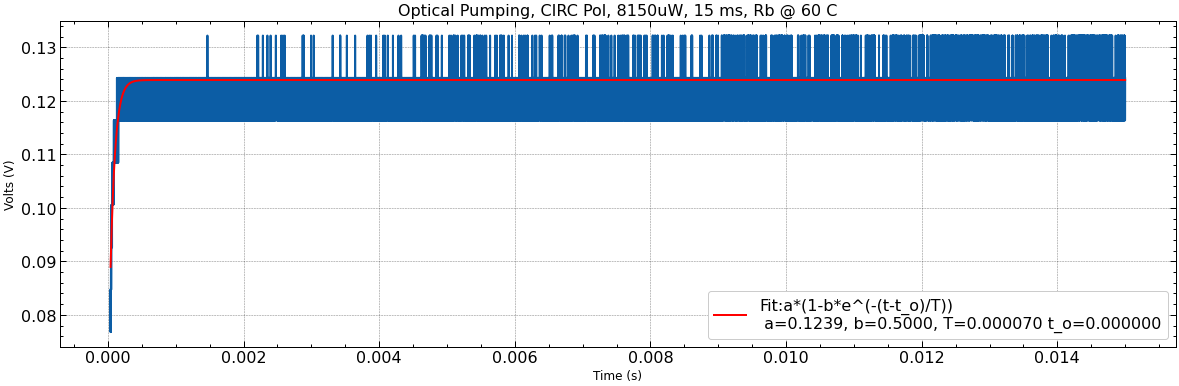

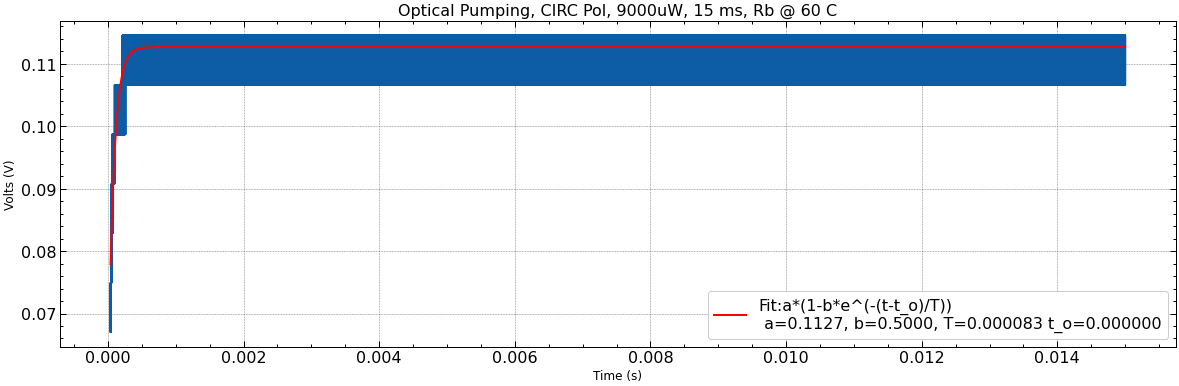

In [93]:


for num in range(11):
    file1 = (root+f"/{POL}{str(pwrs[0])}uW{str(num)}.csv")
    print(file1)
    
    data1 = pd.read_csv(file1)
    
    print(time.ctime())
    
    #  Params for datasets 5-10
#     data2 = cut(data, data['Time(s)'].min(), 0)
#     data3  = dfconcat(data, data2, 0+40*10**-6, 4090*10**-6)
#   40C Phase Lock PGB
#     data2 = cut(data1, data1['Time(s)'].min(), 0)
#     data3  = dfconcat(data1, data2, 1.235*(10**(-6)), 4090*10**-6)
    
    a = data['Time(s)'].min()
    b = 0
    if num == 0 : c = 500*(10**(-6)) 
    elif num in range(1,5): c = 150*(10**(-6)) 
    else: c = 40*(10**(-6))
    d = 15000*10**-6

    data2 = cut(data1, a, b)
    
    data3  = dfconcat(data1, data2, c, d)
    
    # inv_exp(t, a, b, T, t_o)
    fitInitGuess = [0.06, 0.8, 10*10**(-5), 1*10**(-4)]
    fitBounds=((0,0.5,0,0*10**-4),(5.0, 0.9, 0.001, 1*10**(-3)))
    fit(data3, file1, npydir, inv_exp, pwrs[num], TEMP, POL, BRAND, fitInitGuess, fitBounds)

In [88]:
BRANDLONG = 'PrecisionGlassBlowing'
BRAND = 'PGB'
BRANDS =[('PrecisionGlassBlowing', 'PGB')]
POLS = ['CIRC']
TEMPS = ['60']
# root = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
#         +f"{BRANDLONG}/{POL}POL/{TEMP}C_Phase_Locked")

for BRANDLONG, BRAND in BRANDS:
    for POL in POLS:
        for TEMP in TEMPS:
            npydir = (root +"/npy_files")
            globals()[BRAND+POL+TEMP+'_T_list'] = []
            for num in range(11):
                globals()[BRAND+POL+TEMP+'_T_list'].append(np.load(npydir+f"/{POL}{str(200)}uW{str(num)}_{BRAND}{POL}{TEMP}_best_vals.npy")[2])
            print(len(globals()[BRAND+POL+TEMP+'_T_list']))

11


In [85]:
# BRANDLONG = 'PrecisionGlassBlowing'
# BRAND = 'PGB'
# BRANDS =[('PrecisionGlassBlowing', 'PGB')]
# POLS = ['CIRC']
# TEMPS = ["60"]

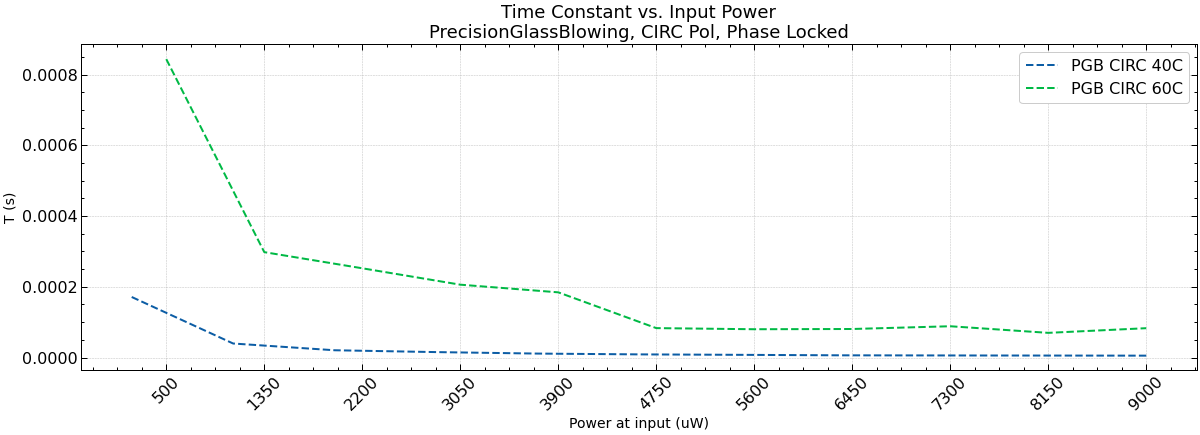

In [95]:
fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
pwrs_40C = [int(x) for x in np.linspace(200, 9000, 11)] # 40C Phase Lock
# pwrs = [int(x) for x in np.linspace(3650, 9150, 11)]# PGB 60C Phase Lock 2
pwrs_60C = [int(x) for x in np.linspace(500,9000,11)] # PGB 60C Phase Locked 15ms
# globals()[BRAND+POL+str(TEMP)+'_T_list'].pop(0)
# pwrs.pop(0)
# globals()[BRAND+POL+str(TEMP)+'_T_list'].pop(0)
# pwrs.pop(0)
# globals()[BRAND+POL+str(TEMP)+'_T_list'].pop(0)
# pwrs.pop(0)
# TEMPS = [('40', pwrs_40C), ('60', pwrs_60C)]
TEMPS = [('60', pwrs_60C)]

for BRANDLONG, BRAND in BRANDS:
    for POL in POLS:
        for TEMP, pwrs in TEMPS:
#             fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
            ax.plot(pwrs,globals()[BRAND+POL+str(TEMP)+'_T_list'], '--',label=BRAND+' '+POL+' '+TEMP+'C')

            ax.set_xlabel('Power at input (uW)', fontsize=14)
            ax.set_ylabel('T (s)', fontsize=14)
            ax.set_xticks(pwrs)
            ax.set_xticklabels(pwrs,rotation=45)
            # ax.invert_xaxis()
            ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
            ax.legend(loc="best")
            # ax.set_title(BRANDLONG+' Cell Transmission, 3 mW, 1.2 ms period',  fontsize=14)
            ax.set_title('Time Constant vs. Input Power\n'+BRANDLONG+', '+POL+' Pol, Phase Locked',  fontsize=18)
#             plt.show()
# plt.savefig(root + f"/TvPwr_{BRAND}_{TEMP}C_Phase_Locked.png")
# plt.savefig(f"/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
#         +f"{BRANDLONG}/{POL}POL/TvPwr_{BRAND}_40C_&_60C_Phase_Locked.png")

In [99]:
((0.0008-0.0002)/((0.0008+0.0002)/2))*100

120.00000000000001

In [102]:
(0.0008-0.0002)/(0.0002)*100

300.0

In [49]:
BRANDLONG = 'PrecisionGlassBlowing'
BRAND = 'PGB'
BRANDS =[('PrecisionGlassBlowing', 'PGB')]
POLS = ['CIRC']
TEMPS = ['60']

for BRANDLONG, BRAND in BRANDS:
    for POL in POLS:
        for TEMP in TEMPS:
            npydir = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/"+TEMP+"C_Phase_Locked_2/npy_files")
            globals()[BRAND+POL+TEMP+'_t_o_list'] = []
            for num in range(11):
                globals()[BRAND+POL+TEMP+'_t_o_list'].append(np.load(npydir+"/"+POL+'3650uW'+str(num)+'_'+BRAND+POL+TEMP+'_best_vals.npy')[2])
            print(len(globals()[BRAND+POL+TEMP+'_t_o_list']))

globals()[BRAND+POL+TEMP+'_t_o_list'] = np.array(globals()[BRAND+POL+TEMP+'_t_o_list'])

globals()[BRAND+POL+TEMP+'_t_o_list'] = globals()[BRAND+POL+TEMP+'_t_o_list']/0.1

type(globals()[BRAND+POL+TEMP+'_t_o_list'])

11


numpy.ndarray

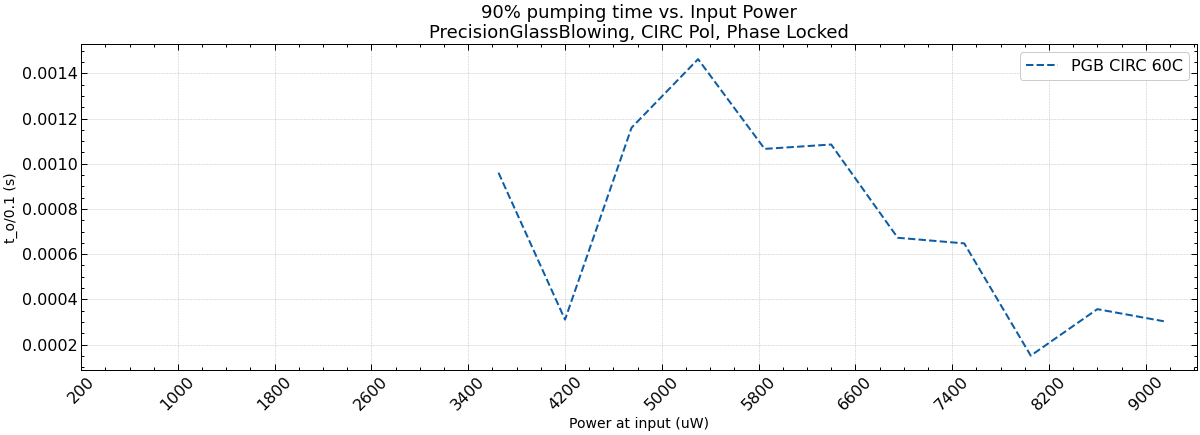

In [51]:
BRANDLONG = 'PrecisionGlassBlowing'
BRAND = 'PGB'
BRANDS =[('PrecisionGlassBlowing', 'PGB')]
POLS = ['CIRC']
pwr_tks = [int(i) for i in np.linspace(200, 9000,12)]

fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
pwrs_40 = [int(x) for x in np.linspace(200, 9000, 11)] # PGB 40C Phase Lock
pwrs_60 = [int(x) for x in np.linspace(3650, 9150, 11)]# PGB 60C Phase Lock 2
TEMPS = [ (pwrs_60,'60')]

for BRANDLONG, BRAND in BRANDS:
    for POL in POLS:
        for pwrs, TEMP in TEMPS:
#             fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
            ax.plot(pwrs, globals()[BRAND+POL+str(TEMP)+'_t_o_list'], '--',label=BRAND+' '+POL+' '+TEMP+'C')

            ax.set_xlabel('Power at input (uW)', fontsize=14)
            ax.set_ylabel('t_o/0.1 (s)', fontsize=14)
            ax.set_xticks(pwr_tks)
            ax.set_xticklabels(pwr_tks,rotation=45)
            # ax.invert_xaxis()
            ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
            ax.legend(loc="best")
            # ax.set_title(BRANDLONG+' Cell Transmission, 3 mW, 1.2 ms period',  fontsize=14)
            ax.set_title('90% pumping time vs. Input Power\n'+BRANDLONG+', '+POL+' Pol, Phase Locked',  fontsize=18)
#             plt.show()
plt.savefig("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +f"{BRANDLONG}/{POL}POL/t_ovPwr_{BRAND}_40C_60C_Phase_Locked.png")

In [78]:
BRANDLONG = 'PrecisionGlassBlowing'
BRAND = 'PGB'
POL = 'CIRC'
TEMP = '60'

# for num in filenums:
file1 = (root+f"/Transmission_{BRAND}_{TEMP}C_Phase_Locked.xlsx")
# file1_f = (f"/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
#          +f"{BRANDLONG}/{POL}POL/{TEMP}C_Phase_Locked/Transmission_{BRAND}_{TEMP}C_Phase_Locked.xlsx")
# Transmission_relataxion_time_CIRC_35C.xlsx
# Transmission_PGB_35C.xlsx
# 60C_Phase_Locked
# Transmission_Thor_60C_Phase_Locked

dataframe1 = pd.read_excel(file1)
 
# print(dataframe1)

dataframe1['Transmission (%)'] = (dataframe1['Cell (mV_pp)'] / dataframe1['No Cell (mV_pp)'])*100

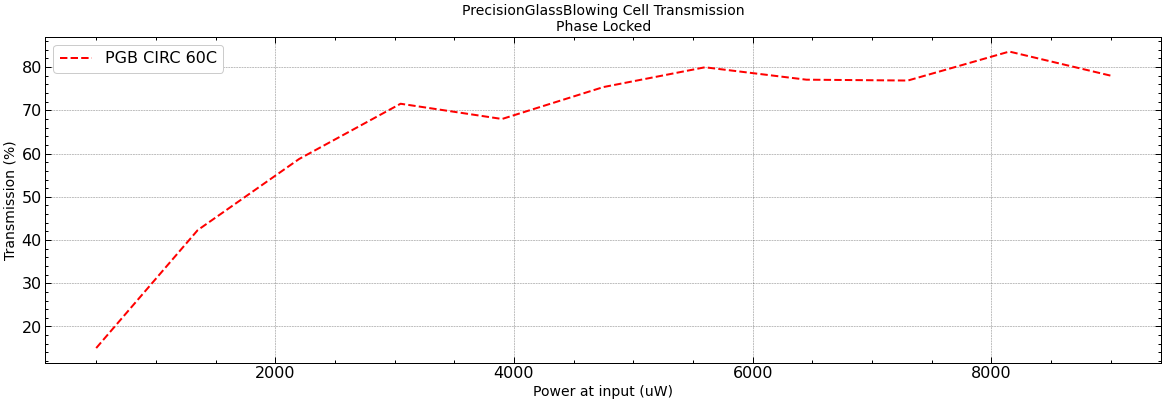

In [79]:
fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
ax.plot(dataframe1['Pwr (uW)'] , dataframe1['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C',color='red')
ax.set_xlabel('Power at input (uW)', fontsize=14)
ax.set_ylabel('Transmission (%)', fontsize=14)
# ax.invert_xaxis()
# ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
ax.legend(loc="best")
ax.set_title(BRANDLONG+' Cell Transmission\nPhase Locked',  fontsize=14)
# plt.savefig("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
#              +BRANDLONG+"/"+POL+"POL/"+TEMP+"C/Transmission_PGB_"+TEMP+"C.png")

plt.savefig(root+f"/Transmission_{BRAND}_{TEMP}C_Phase_Locked.png")

In [3]:
[int(x) for x in np.linspace(500,9000,11)]

[500, 1350, 2200, 3050, 3900, 4750, 5600, 6450, 7300, 8150, 9000]

In [3]:
seed_pwr = [4.3,6.6,9.8,13,16.5,19.3,22.6,26,29.1,31.7,34.3,38.4]
output_pwr = [919,1084,1131,1160,1178,1191,1201,1212,1219,1223,1227,1233]

No handles with labels found to put in legend.


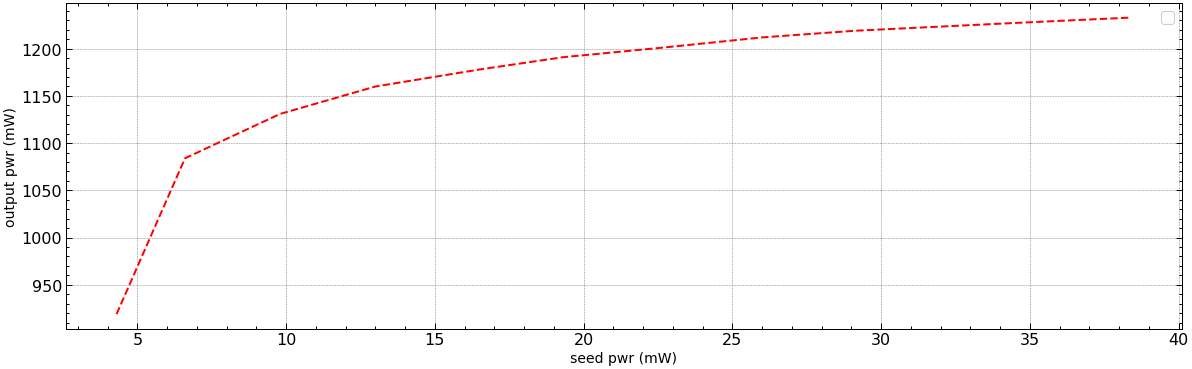

In [5]:
fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
ax.plot(seed_pwr, output_pwr, '--',color='red')
ax.set_xlabel('seed pwr (mW)', fontsize=14)
ax.set_ylabel('output pwr (mW)', fontsize=14)
# ax.invert_xaxis()
# ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
ax.legend(loc="best")
# ax.set_title(BRANDLONG+' Cell Transmission\nPhase Locked',  fontsize=14)
# plt.savefig("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
#              +BRANDLONG+"/"+POL+"POL/"+TEMP+"C/Transmission_PGB_"+TEMP+"C.png")

# plt.savefig(root+f"/Transmission_{BRAND}_{TEMP}C_Phase_Locked.png")